# Speed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import os
import time
import warnings

# local
from LSM import MonteCarloOptionPricing
from DC import DynamicChebyshev

# Speed of Dynamic Chebyshev

In [8]:
# Number of options to test
num_options_list = [1, 2, 5, 10, 25, 50]

runtimes_offline = []
runtimes_online = []

for num_options in num_options_list:
    # Define a range of strikes for the number of options
    strikes_range = np.linspace(0.8 * 36, 1.2 * 36, num_options)

    total_time_offline = 0
    total_time_online = 0

    for K in strikes_range:
        DC_option_pricing = DynamicChebyshev(r=0.06, S0=36., K=K, T=1., σ=0.2, λ=0.4, dim=1_000, n=100, n_chebyshev_pol=10, seed=150_000)
        # offline phase
        start_time_offline = time.time()
        domain = DC_option_pricing.calculate_truncated_domain_GBM()
        xknots = DC_option_pricing.calculate_nodal_points(domain)
        BS = DC_option_pricing.generate_GBM_path(xknots)
        Γ = DC_option_pricing.compute_generalized_moments(domain, xknots)
        end_time_offline = time.time()
        total_time_offline += end_time_offline - start_time_offline

        # online phase
        start_time_online = time.time()
        DC_price = DC_option_pricing.price_option_with_dynamic_chebyshev(xknots, Γ)
        end_time_online = time.time()
        total_time_online += end_time_online - start_time_online

    runtimes_offline.append(total_time_offline)
    runtimes_online.append(total_time_online)

In [4]:
# Suppress RankWarning
warnings.filterwarnings('ignore', category=np.RankWarning) # due to poly overfit when using poly_degree > 10
# Number of options to test
num_options_list = [1, 2, 5, 10, 25, 50]

runtimes_LSM5 = []
runtimes_LSM20 = []

for num_options in num_options_list:
    # Define a range of strikes for the number of options
    strikes_range = np.linspace(0.8 * 36, 1.2 * 36, num_options)

    total_time_LSM5 = 0
    total_time_LSM20 = 0

    for K in strikes_range:
        mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=36., K=40., T=2., σ=0.2, λ=0.4, dim=1_000, n=10, seed=150_000)
        
        # LSM for 3 basis functions
        start_time_LSM5 = time.time()
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
        mc_option_pricing.american_option_LSM(poly_degree = 3, otype= 'put')
        end_time_LSM5 = time.time()
        total_time_LSM5 += end_time_LSM5 - start_time_LSM5

        # LSM for 15 basis functions
        start_time_LSM20 = time.time()
        simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec() 
        mc_option_pricing.american_option_LSM(poly_degree = 15, otype= 'put')
        end_time_LSM20 = time.time()
        total_time_LSM20 += end_time_LSM20 - start_time_LSM20

    runtimes_LSM5.append(total_time_LSM5)
    runtimes_LSM20.append(total_time_LSM20)

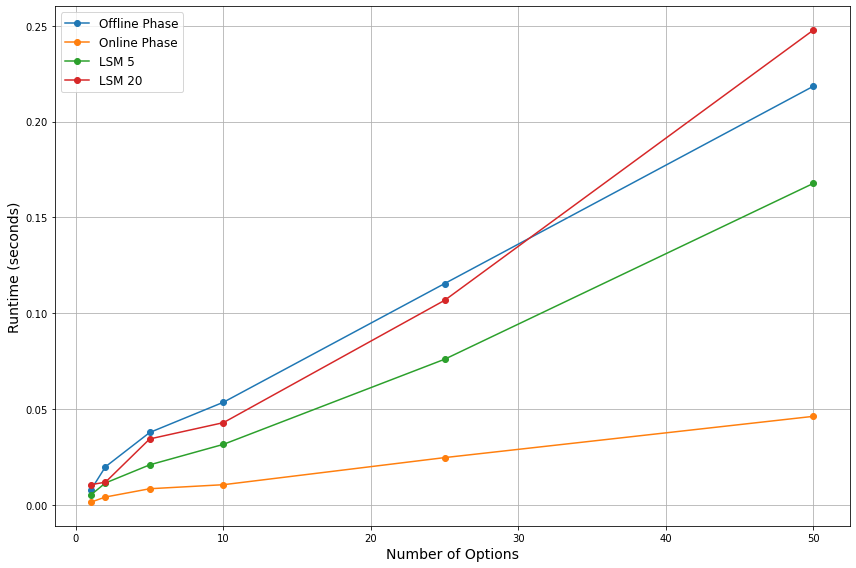

In [9]:
# Plotting Runtime vs. Number of Options
plt.figure(figsize=(12, 8))
plt.plot(num_options_list, runtimes_offline, marker='o', label='Offline Phase')
plt.plot(num_options_list, runtimes_online, marker='o', label='Online Phase')
plt.plot(num_options_list, runtimes_LSM5, marker='o', label='LSM 5')
plt.plot(num_options_list, runtimes_LSM20, marker='o', label='LSM 20')
plt.xlabel('Number of Options',size=14)
plt.ylabel('Runtime (seconds)',size=14)
#plt.title('Runtime (Offline and Online) of Dynamic Chebyshev Method | LSM vs. Number of Options')

plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()

if not os.path.exists("../Results/plots"):
    os.makedirs("../Results/plots")
    
plt.savefig("../Results/plots/SpeedComparison.pdf", bbox_inches='tight')

plt.show()